In [27]:
def  proxid():
    
    clust_arr=[]
    str_loc_names=[]
    
    for i in range(int(input("Number of Sample People: "))):
        loc=input("File Location: ")
        print ("Sample {}: ".format(i+1))
        temp=freq_locations(loc)
        str_loc_names.append(loc)
        for j in temp:
            tempj=[i,j]
            clust_arr.append(tempj)
        
    clust_arr=np.array(clust_arr)
    clust_arr_comb=list(combinations(clust_arr,2))
    clust_arr_comb=np.array(clust_arr_comb)
    
    ct=0
    
    for x  in clust_arr_comb:
        diff=0
        if x[0][0]!=x[1][0]:
            diff=math.sqrt(((x[0][1][0]-x[1][1][0])**2)+((x[0][1][1]-x[1][1][1])**2))
            diff*=7.871e3
            if diff<120:
                fintime=predtime(str_loc_names[x[0][0]],x[0][1][0],x[1][1][0])
                hour=int(fintime[0])
                minute=int((fintime[0]%hour)*60)
                second=int((fintime[0]/minute)*60)
                print ("Persons {} and {} in proximity of {:.3f} metres at time: {}:{}:{}".format(x[0][0],x[1][0],diff,hour,minute,second))
    
        

In [ ]:
#function to predict location based on time

def checkloc(str_loc):
    locdata=[]
    names=['date','time','latitude','longitude']
    try:
        locdata=pd.read_excel(str_loc,names=names) 
        pass
    except IOError:
        print ("Could not read file: {}\n".format(str_loc))
        
    tim=[(i.hour+(i.minute/60)+(i.second/3600)) for i in tm] 
    
    #Using Regression to predict location at a particular time
    loctim=[list(a) for a in zip(tim,locdata['latitude'],locdata['longitude'])]
    loctim=np.array(loctim)

    #function to  take input of time
    def inputtime():
        inp=input("Enter the time at which location is to be predicted: ")
        tim=inp.split(":")
        ret=(int(tim[0])+(int(tim[1])/60)+(int(tim[2])/3600))
        return float(ret)

    query=[inputtime()]
    print("\n")

    #Splitting the data and applying the Decision Tree Regressor
    EX_train = loctim[:, 0]
    ylat_train=np.log(loctim[:,1])
    ylon_train=np.log(loctim[:,2])
    EX_train=EX_train.reshape(-1,1)

    treelon=DecisionTreeRegressor(random_state=0).fit(EX_train,ylon_train)
    treelat=DecisionTreeRegressor(random_state=0).fit(EX_train,ylat_train)

    query=np.array(query)
    query=query.reshape(1,-1)

    lontree=treelon.predict(query)
    lattree=treelat.predict(query)

    finlon=np.exp(lontree)
    finlat=np.exp(lattree)

    print("Location Found: ({:.4f} , {:.4f}) \n".format(finlat[0],finlon[0]))
    mglearn.discrete_scatter(finlat,finlon,markers='s',c='r',markeredgewidth=3)

In [49]:
#function to return cluster centers based on the location history of a person

def freq_locations():
    #importing the data from excel file
    locdata=[]
    names=['date','time','latitude','longitude']
    loc= input("Enter location of the file to be read\n")
    
    try:
        locdata=pd.read_excel(loc,names=names) 
        pass
    except IOError:
        print ("Could not read file: {}\n".format(str_loc))

    #modifying the list and splitting it to be input into the algorithms
    finloc=[list(a) for a in zip(locdata['latitude'],locdata['longitude'])]
    
    #Function to find the optimum value of k in kmeans clustering using elbow method
    def optimumk(X_train_scaled):
        Sum_of_squared_distances = []
        K = range(1,15)
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(X_train_scaled)
            Sum_of_squared_distances.append(km.inertia_)
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum of squared distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()
    
        kn = KneeLocator(K,Sum_of_squared_distances,curve='convex',direction='decreasing')
        x=kn.knee   
        return (x)
    
    n=optimumk(finloc)

    #Applying KMeans clustering algorithm
    kmeans=KMeans(n_clusters=n,random_state=4321)
    kmeans.fit(finloc)
    ndarray = kmeans.cluster_centers_.tolist()
    
    #Converting time into decimals   
    tm=locdata['time'].tolist()
    tim=[(i.hour+(i.minute/60)+(i.second/3600)) for i in tm]
    
     #Splitting the data for K-nearest neighbour classifier to predict home and office location
    target=[]
    for x in tim:
        if  x>19.0 or x<10.0:  #if home; target is 1
            target.append(1)
        else:                  #if office or outside; target is 0
            target.append(0)
    
    loctim=[list(a) for a in zip(tim,locdata['latitude'],locdata['longitude'])]
    loctim=np.array(loctim)
    
    timloc=[list(a) for a in zip(locdata['latitude'],locdata['longitude'],target)]
    timloc=np.array(timloc)
    
    #Printing
    print ("Number of Clusters: {}\n".format(n))
            
    plt.scatter(locdata['latitude'],locdata['longitude'],alpha=0.4)
    
    #function to predict time based on location
    def predtime(lat,lon):
        #Using Regression to predict location at a particular time
        EX_train_lat=loctim[:,1]
        EX_train_lon=loctim[:,2]
        y_train=loctim[:,0]
        EX_train_lat=EX_train_lat.reshape(-1,1)
        EX_train_lon=EX_train_lon.reshape(-1,1)

        treelon=DecisionTreeRegressor(random_state=0).fit(EX_train_lon,y_train)
        treelat=DecisionTreeRegressor(random_state=0).fit(EX_train_lat,y_train)
    
        lon=[lon]
        lat=[lat]
    
        lon=np.array((lon))
        lat=np.array((lat))
    
        lon=lon.reshape(-1,1)
        lat=lat.reshape(-1,1)
    
        finlontime=treelon.predict(lon)
        finlattime=treelat.predict(lat)

        fintime=(finlontime+finlattime)/2
    
        return fintime
       
    #Finding radii of clusters 
    h=0
    dist=[]
    temp=0
    res=kmeans.predict(ndarray)

    for h in range(len(finloc)):
        for k in res:
                if kmeans.labels_[h]==k:
                    temp=math.sqrt((finloc[h][0]-ndarray[k][0])**2+(finloc[h][1]-ndarray[k][1])**2)
                    dist.append(temp)
                    
    cluster_radii=[]

    for o in res:
        r=[]
        for d in range(len(dist)):
            if o==kmeans.labels_[d]:
                r.append(dist[d]*7.871e3)       #Conversion to metres from degree co-ordinates
        cluster_radii.append(max(r))

    for c in range(len(cluster_radii)):
        print("Cluster {}: {} Radius : {:.4f} m\n".format((c+1),ndarray[c],cluster_radii[c]))
        
    #Finding the accuracy of location detection
    mean=np.mean(cluster_radii)
    median=np.median(cluster_radii)
    deviation=np.std(cluster_radii)
    
    print ("Location Accuracy: {:.4f} m\n".format(mean))
        

    X_train, X_test,y_train,y_test=train_test_split(timloc[:,[0,1]],timloc[:,2],random_state=42)

    #Scaling and transforming
    scaler=MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled=scaler.transform(X_train)

    #Applying K neighbours classifier
    knn=KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)

    print ("Evaluating at test score: {:.3f}\n".format(knn.score(X_test,y_test)))

    arr=np.array(ndarray)
 
    #ignoring clusters based on time and cluster radii
    clust_time=[predtime(arr[ctr][0],arr[ctr][1]) for ctr in range(len(arr))]
    clust_time=np.array(clust_time)
    homctr=0
    offctr=0
    for i in clust_time:
        if i>10 and i<18:
            offctr+=1
        elif i>18 or i<10:
            homctr+=1
    
    if offctr>1 or homctr!=1:
        
        off=[cluster_radii[i] for i in range(len(clust_time)) if clust_time[i]>10 and clust_time[i]<18]
        hom=[cluster_radii[i] for i in range(len(clust_time)) if clust_time[i]<10 or clust_time[i]>18]
        
        for v in range(len(arr)-1):
            if (clust_time[v][0]>10 and clust_time[v][0]<18) and cluster_radii[v]!=min(off):
                print ("Ignored Cluster: {} with radius {:.2f} m\n".format(arr[v],cluster_radii[v]))
                cluster_radii=np.delete(cluster_radii,v)
                arr=np.delete(arr,v,axis=0)
            
            elif (clust_time[v][0]<10 or clust_time[v][0]>19) and cluster_radii[v]>min(hom):
                print ("Ignored Cluster: {} with radius {:.2f} m\n".format(arr[v],cluster_radii[v]))
                cluster_radii=np.delete(cluster_radii,v)
                arr=np.delete(arr,v,axis=0)  
    
    clust_size=len(arr)
    
    if (clust_size==2):
        emptype=0
    elif(clust_size>2):
        emptype=1
    else:
        emptype=-1
        
    temploc0=[]
    #assigning type of employee
    if(emptype==0):                              #type 0 for office desk job
        print ("Type: Office Desk Job\n")
        for x in arr:
            x=x.reshape(1,-1)
            y_pred=knn.predict(x)
    
            if(y_pred[0]==0):
                print("Office Location: {} \n".format(x))
                temploc0.append(x)
            elif(y_pred[0]==1):
                print("Home Location: {} \n".format(x))
                temploc0.append(x)
        
        offhomdist=math.sqrt(((temploc[0][0]-temploc[1][0])**2)+((temploc[1][1]-temploc[0][1])**2))
        offhomdist*=7.871e4
        
        print ("Office Home Distance: {:.2f} m".format(offhomdist))
    
    if(emptype==1):                               #type 1 for outdoor job
        print ("Type: Outdoor Job\n")
        temp1=[]
        temp2=[]
        temploc1=[]
        for x in range(len(timloc)):
            if timloc[x][2]==1:
                temp1.append(tim[x])
            elif timloc[x][2]==0:
                tmp=[tim[x],x]
                temp2.append(tmp)   
                
        temparr=[i for i in temp1 if i>7 and i<12]
        maxhome=max(temparr)
        minclusterarr=np.array(temp2)[:,0]
        mincluster=min(minclusterarr)
        topred=finloc[tim.index(mincluster)]
        topred=np.array(topred)
        topred=topred.reshape(1,-1)
        reqcluster=kmeans.predict(topred)
        
        tdiff=abs(maxhome-mincluster)
        
        if(tdiff<1.5):                                     #Estimated time taken to travel=1.5 hours
            for i in ndarray:
                i=np.array(i)
                i=i.reshape(1,-1)
                if kmeans.predict(i)==reqcluster[0]:
                    ofclust=i
                    break
                    
            for f in np.array(ndarray):
                f=f.reshape(1,-1)
                pred=knn.predict(f)
                if pred[0]==1:
                    homeloc=f

        print ("Office Location: {}\n".format(ofclust))    #First location visited after leaving home
        print ("Home Location: {} \n".format(homeloc))
        
        temploc1.append(ofclust[0])
        temploc1.append(homeloc[0])
        offhomdist=math.sqrt(((temploc1[0][0]-temploc1[1][0])**2)+((temploc1[1][1]-temploc1[0][1])**2))
        offhomdist*=7.871e4
        print ("Office Home Distance: {:.2f} m".format(offhomdist))
    if(emptype==-1):                                     #type -1 for ambiguous trends
        print ("Ambiguous Location Trends: Couldn't Classify\n")
       
        
    mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1], [i for i in range(n)],markers='^', markeredgewidth=2)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Centroid of Clusters') 
 
    

System Version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
NumPy Version: 1.16.2
Pandas Version: 0.24.2
Mglearn Version: 0.1.7
Matplotlib Version: 3.0.3
SciPy Version: 1.2.1
Sklearn Version: 0.20.3
IPython Version: 7.4.0




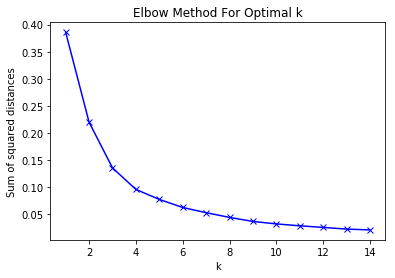

Number of Clusters: 4

Cluster 1: [19.173279870333666, 72.83173040372694] Radius : 285.6966 m

Cluster 2: [19.124526534709016, 72.82636129755149] Radius : 282.4528 m

Cluster 3: [19.174480841653413, 72.87343328820361] Radius : 276.2352 m

Cluster 4: [19.12328745014961, 72.87489867933337] Radius : 257.0354 m

Location Accuracy: 275.3550 m

Evaluating at test score: 0.647

Ignored Cluster: [19.17327987 72.8317304 ] with radius 285.70 m

Type: Outdoor Job

Office Location: [[19.12452653 72.8263613 ]]

Home Location: [[19.12328745 72.87489868]] 

Office Home Distance: 3821.62 m


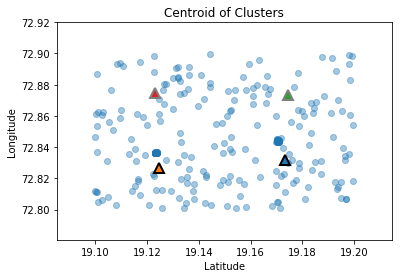

In [53]:
%matplotlib inline
import sys
print ("System Version: {}".format(sys.version))
import numpy as np
print ("NumPy Version: {}".format(np.__version__))
import pandas as pd
print ("Pandas Version: {}".format(pd.__version__))
import mglearn
print ("Mglearn Version: {}".format(mglearn.__version__))
import matplotlib.pyplot as plt
import matplotlib as mpl
print ("Matplotlib Version: {}".format(mpl.__version__))
import scipy as sp
print ("SciPy Version: {}".format(sp.__version__))
import sklearn
print("Sklearn Version: {}".format(sklearn.__version__))
import IPython
print ("IPython Version: {}\n\n".format(IPython.__version__))
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import math
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from datetime import time
from sklearn.tree import DecisionTreeRegressor
from kneed import KneeLocator
from itertools import combinations
import re

if __name__=="__main__":
    freq_locations()
